In [4]:
using SemiClassicalMC
using LinearAlgebra
using HDF5
using PyPlot

# SemiClassicalMC

This package allows the semi-classical analysis of $\mathfrak{su}(4)$ spin models using Metropolis Monte Carlo and simulated annealing algorithms. It can treat models with Hamiltonians of the form

$$H = 
\sum_{ij} \sum_{a, b = 1}^{15} T^a_i\ J_{ij}^{ab}\ T^b_j + \sum_{i}\sum_{a = 1}^{15} B^{a}T_i^a 
\equiv  
\sum_{ij} \sum_{\mu,\nu,\kappa,\lambda = 0}^3(\sigma_i^\mu \otimes \tau_i^\kappa)\ J_{ij}^{\mu\nu\kappa\lambda} (\sigma_j^\nu \otimes \tau_j^\lambda) + \sum_{i}\sum_{\mu,\kappa = 0}^3 B^{\mu\kappa} (\sigma_i^\mu \otimes \tau_i^\kappa)
$$

The spin-valley operators $T^a \equiv \sigma_i^\mu \otimes \tau_i^\kappa$ are generators of the Lie-Group SU(4) and defined via a fermionic parton decomposition as

$$\sigma^\mu_i \otimes \tau^\nu_i = P_n f^\dagger_{isl} \theta^{\mu}_{ss'} \theta^\nu_{ll'} f_{is'l'}, $$

where $\theta^\mu$ are the Pauli matrices (with $\theta^0 = 1$) and $P_n$ is the projector on the subspace of $n$ partons per site, i.e. exactly enforcing $f^\dagger_{isl}f_{isl} = n = 1, 2$. The coupling matrix $J$ can be completely off-diagonal, except for on-site interactions ($i = j$), where we demand it to be diagonal in the sense that $J_{ii}^{\mu\nu\kappa\lambda} \sim \delta_{\mu,\nu} \delta_{\kappa,\lambda}$ or $J_{ii}^{a,b}\sim \delta_{a,b}$ The Hamiltonian can be defined on arbitrary lattice graphs using the [LatticePhysics.jl](https://github.com/janattig/LatticePhysics.jl) package. 

By "semi-classical" we refer to the limit of no entanglement between different lattice sites, which is enforced by making a product-state ansatz for the wave function. In this limit, finite-temperature observables can by efficiently calculated by sampling the state of product-state wave functions via Monte Carlo algorithms. The package implements a standard Metropolis Monte Carlo with adaptive step-size for finite temperature calculations, and a minimization scheme using simulated annealing with subsequent stochastic gradient descent to efficiently obtain the semi-classical ground state. Details on the algorithms are described in the appendix of [our preprint](https://doi.org/10.48550/arXiv.2303.01244).

## Implementing a lattice model

Internally, the coupling matrices $J_{ij}^{ab}$ are stored as a 16x16 matrix, where the components $a, b$ are defined so that $J^{ab}_{ij}$ corresponds to the coupling between $T^a_i$ and $T^b_j$ with 

$$T^a = (\sigma \otimes \tau)^a = 
\sigma^0\tau^x, \sigma^0\tau^y, \sigma^0\tau^z,
\sigma^x\tau^x, \sigma^x\tau^y, \sigma^x\tau^y, \sigma^x\tau^z,
\sigma^y\tau^x, \sigma^y\tau^y, \sigma^y\tau^y, \sigma^y\tau^z,
\sigma^z\tau^x, \sigma^z\tau^y, \sigma^z\tau^y, \sigma^z\tau^z)^a.
$$

For a Hamiltonian that can be factorized as 
$$(\sigma_i^\mu \otimes \tau_i^\kappa)\ J_{ij}^{\mu\nu\kappa\lambda} (\sigma_j^\nu \otimes \tau_j^\lambda) =
(\sigma_i^\mu \otimes \tau_i^\kappa)\ J_{s, ij}^{\mu\nu} J_{v, ij}^{\kappa\lambda} (\sigma_j^\nu \otimes \tau_j^\lambda)$$

this definition of the coupling matrix $J$ corresponds to the standard [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) $J = J_s \otimes J_v$ (omiting the first column and row, i.e. taking only the slice [2:16, 2:16], which corresponds to ommiting the density-spin, spin-density and density-density couplings). As an example consdier the SU(2) $\otimes$ SU(2) symmetric Hamiltonain on the honeycomb lattice defined by

$$H = \sum_{\langle ij\rangle}\left[I_{sv}(\sigma_i^\mu \otimes \tau_i^\nu) (\sigma_j^\mu \otimes \tau_j^\nu) + I_s \sigma^\mu_i \sigma^\mu_j + I_v \tau^\nu_i \tau^\nu_j \right],$$

for which the fully diagonal coupling matrix reads

$$ J = \mathtt{diagm}([I_v, I_v, I_v, I_s, I_{sv}, I_{sv}, I_{sv}, I_s, I_{sv}, I_{sv}, I_{sv}, I_s, I_{sv}, I_{sv}, I_{sv}]).$$

To run a Monte Carlo calculation on this Hamiltonian, we first need to initialize a `Configuration` as follows:

In [5]:
using LatticePhysics

#Set couplings
Isv, Is, Iv = 0.2, -1.0, 0.2

#Coupling matrix
J = diagm([Iv, Iv, Iv, Is, Isv, Isv, Isv, Is, Isv, Isv, Isv, Is, Isv, Isv, Isv])

#Put all interactions into a vector (in case there are different interactions)
interactions = [J]

#Specify on-site interaction as 15 dimensional vector (diagonal of coupling matrix)
onsiteInteraction = zeros(Float64, 15) #Here all are zero

#Specify constant magnetic field
B = zeros(Float64, 15)

## Initialize lattice with bonds
uc = getUnitcell(:triangular, Int64, Int64)

# Clear bonds for illustration (default bonds are isotropic nearest neighbor interactions)
uc.bonds = [] 
             
#Add bonds to unit-cell
label = 1  #Label the bonds by their index in the 'interactions' vector (here all label = 1)
add_reverse = true #For i->j also add j->i
addBond!(uc, 1, 1, label, (1, 0),  add_reverse)
addBond!(uc, 1, 1, label, (0, -1), add_reverse)
addBond!(uc, 1, 1, label, (-1, 1), add_reverse)

#Specify lattice parameters
latticename = "triangular"
L = 12 #Linear lattice size (create LxL unitcells)

#Specify the parton filling
n = 1

#initialize configuration
cfg = Configuration(latticename, L, uc, interactions, n; onsiteInteraction = onsiteInteraction, B = B);

# Predefined models

There are a couple of pre-defined Models in the "Models.jl" file, which can directly be initialized. For a more complicated example, we implemented the spin-valley Hamiltonian for trilayer graphene on hexagonal boron nitride (TG-h/BN) derived by Zhang and Senthil in [Phys. Rev. B 99, 205150](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.205150), which contains on-site, non-isotropic nearest-neighbor and and next-nearest-neighbor interactions (see src/Models.jl). We have also implemented a model for general isotropic nearest neighbor interactions. Using this, the SU(2) $\otimes$ SU(2) Hamiltonian defined above can be initialized as

In [6]:
J = [diagm([Iv, Iv, Iv, Is, Isv, Isv, Isv, Is, Isv, Isv, Isv, Is, Isv, Isv, Isv])] #Nearest neighbor coupling matrices
B = zeros(Float64, 15)
L = 6  #Linear lattice size (create LxL unitcells)
n = 1 #Filling of one parton per site
model = "nearest-neighbor"
latticename = "triangular"
cfg = initializeCfg(model, latticename, J, L, n; B = B);

# Finite temperature calculation

### Launching manually

Once a configuration is initialized, a finite temperature calculation can be run.

In [7]:
obs_type = ObservablesGeneric # Type of observables (enables custom observables type)
T = 0.02                      # Simulation temperature
T_i = 1.0                     # Temperature to start thermalization from (simulated annealing for thermalization sweeps)
N_therm = 100000              # Number of thermalization sweeps
N_measure = 100000;           # Number of measurement sweeps
outfile = "MC_example.h5"     # Output file where observables are saved
measurement_rate = 10         # Measure every "measurement_rate" sweeps
checkpoint_rate = 20000       # Create checkpoint every "checkpoint_rate" sweeps
report_rate = 20000           # Progress report every "report_rate" sweeps

#initialize observables (for details on custom obsevables below)
obs = initializeObservables(obs_type, cfg)
run!(cfg, obs, T, T_i, N_therm, N_measure, outfile; 
     measurement_rate = measurement_rate, 
     checkpoint_rate = checkpoint_rate, 
     report_rate = report_rate)

MC_example.h5: Initializaing output ----
MC_example.h5: Starting thermalization sweeps
MC_example.h5: 20000/100000 thermalization sweeps. T = 0.3523, R = 0.5181, σ = 0.09825.
MC_example.h5: 40000/100000 thermalization sweeps. T = 0.1241, R = 0.4625, σ = 0.04919.
MC_example.h5: 60000/100000 thermalization sweeps. T = 0.04373, R = 0.5278, σ = 0.0289.
MC_example.h5: 80000/100000 thermalization sweeps. T = 0.02, R = 0.4833, σ = 0.01924.
MC_example.h5: 100000/100000 thermalization sweeps. T = 0.02, R = 0.5542, σ = 0.02104.
MC_example.h5: Starting measurement sweeps at sweep 0/100000, T = 0.02. R = 0.5542, σ = 0.02104.
MC_example.h5: 20000/100000 measurement sweeps at 0.4664 acceptance rate.
MC_example.h5: 40000/100000 measurement sweeps at 0.4662 acceptance rate.
MC_example.h5: 60000/100000 measurement sweeps at 0.4664 acceptance rate.
MC_example.h5: 80000/100000 measurement sweeps at 0.4658 acceptance rate.
MC_example.h5: 100000/100000 measurement sweeps at 0.466 acceptance rate.
MC_exampl

Observables are saved at the end of the calculation in the output file under the group "means". You can create your custom `Observables` subtype to determine what is measured (see "Observables/ObservablesGeneric.jl" and "Observables/ObservablesTgHbn" for two examples). Additional to the "means" of the defined observables, the energy per site time series is saved in the field `f["energies"]` to check for thermalization and for histogram analysis.

In [8]:
#Structure of output file
f = h5open(outfile)
display(f)

#Extract some scalar observables
@show σ = f["means/σ/mean"][]          #spin magnetization
@show σ = f["means/σ/error"][]         #error
@show τ = f["means/τ/mean"][]          #valley magnetization
@show dτ = f["means/τ/error"][]        #error
@show στ= f["means/στ/mean"][]         #spin-valley magnetization
@show dστ= f["means/στ/error"][]       #error
@show e = f["means/energy/mean"][]    #energy per site
@show de = f["means/energy/error"][]  #error
@show heat = f["means/heat/mean"][]   #specific heat
@show dheat = f["means/heat/error"][] #error
close(f)

🗂️ HDF5.File: (read-only) MC_example.h5
├─ 🔢 cfg
├─ 🔢 current_sweep
├─ 🔢 energy
├─ 📂 means
│  ├─ 📂 correlations
│  │  ├─ 🔢 error
│  │  └─ 🔢 mean
│  ├─ 📂 energy
│  │  ├─ 🔢 error
│  │  └─ 🔢 mean
│  ├─ 📂 heat
│  │  ├─ 🔢 error
│  │  └─ 🔢 mean
│  ├─ 📂 magnetizationVec
│  │  ├─ 🔢 error
│  │  └─ 🔢 mean
│  ├─ 📂 σ
│  │  ├─ 🔢 error
│  │  └─ 🔢 mean
│  ├─ 📂 στ
│  │  ├─ 🔢 error
│  │  └─ 🔢 mean
│  └─ 📂 τ
│     ├─ 🔢 error
│     └─ 🔢 mean
├─ 🔢 obs
├─ 🔢 rs
├─ 🔢 βs
└─ 🔢 σ

σ = (f["means/σ/mean"])[] = 0.9932141458640691
σ = (f["means/σ/error"])[] = 1.1680890425296305e-5
τ = (f["means/τ/mean"])[] = 0.01980650666349839
dτ = (f["means/τ/error"])[] = 0.00013021262369482145
στ = (f["means/στ/mean"])[] = 0.028781256238597633
dστ = (f["means/στ/error"])[] = 0.0001007148816037642
e = (f["means/energy/mean"])[] = -3.54106842531069
de = (f["means/energy/error"])[] = 8.141541532640257e-5
heat = (f["means/heat/mean"])[] = 2.9254766460518056
dheat = (f["means/heat/error"])[] = 0.044972469743661744


### Launching with launch! function 

Predefined models can also directly be launched from the `launch!` function

In [9]:
launch!(outfile, model, n, obs_type, latticename, L, J, T, T_i, N_therm, N_measure;
        measurement_rate = measurement_rate, checkpoint_rate = checkpoint_rate, report_rate = report_rate, 
        overwrite = true)

MC_example.h5: Overwrite = true, starting from scratch.
MC_example.h5: Initializaing output ----
MC_example.h5: Starting thermalization sweeps
MC_example.h5: 20000/100000 thermalization sweeps. T = 0.3523, R = 0.5333, σ = 0.1016.
MC_example.h5: 40000/100000 thermalization sweeps. T = 0.1241, R = 0.4972, σ = 0.05208.
MC_example.h5: 60000/100000 thermalization sweeps. T = 0.04373, R = 0.5014, σ = 0.02922.
MC_example.h5: 80000/100000 thermalization sweeps. T = 0.02, R = 0.4486, σ = 0.0177.
MC_example.h5: 100000/100000 thermalization sweeps. T = 0.02, R = 0.5597, σ = 0.02011.
MC_example.h5: Starting measurement sweeps at sweep 0/100000, T = 0.02. R = 0.5597, σ = 0.02011.
MC_example.h5: 20000/100000 measurement sweeps at 0.4854 acceptance rate.
MC_example.h5: 40000/100000 measurement sweeps at 0.4853 acceptance rate.
MC_example.h5: 60000/100000 measurement sweeps at 0.4848 acceptance rate.
MC_example.h5: 80000/100000 measurement sweeps at 0.4848 acceptance rate.
MC_example.h5: 100000/100000

### Checkpointing

Starting from a checkpoint can be done by setting `overwrite = false`. Here, we also need to increase `N_measure`, as otherwise the solver thinks it is already done. If, e.g., after a finished calculation we want to double the number of measurement sweeps, we can do

In [10]:
launch!(outfile, model, n, obs_type, latticename, L, J, T, T_i, N_therm, N_measure * 2;
        measurement_rate = measurement_rate, checkpoint_rate = checkpoint_rate, report_rate = report_rate, 
        overwrite = false)

MC_example.h5: Overwrite = false, trying to load data and continue calculations
MC_example.h5: Initializaing output ----
MC_example.h5: Starting measurement sweeps at sweep 100000/200000, T = 0.02. R = 0.5, σ = 0.02011.
MC_example.h5: 120000/200000 measurement sweeps at 0.4848 acceptance rate.
MC_example.h5: 140000/200000 measurement sweeps at 0.4859 acceptance rate.
MC_example.h5: 160000/200000 measurement sweeps at 0.4845 acceptance rate.
MC_example.h5: 180000/200000 measurement sweeps at 0.4852 acceptance rate.
MC_example.h5: 200000/200000 measurement sweeps at 0.4857 acceptance rate.
MC_example.h5: Measurement sweeps finished. Ending calculation.
MC_example.h5: Calculation finished


### Creating launcher files

It is also possible to create launcherfiles which you can execute by `include`, which is handy when doing several similar calculations. The following code creates a launcherfile "MC_example.jl", which calls the launch function with the same arguments as above (with `outfile` automatically set to "MC_example.h5")

In [11]:
#Save launcher file
saveLauncher("MC_example.jl", model, n, obs_type, latticename, L, J, T, T_i, N_therm, N_measure; B = zeros(Float64, 15),
            measurement_rate = measurement_rate, checkpoint_rate = checkpoint_rate, report_rate = report_rate, 
            overwrite = true)

#Run file
include("MC_example.jl")

MC_example.h5: Overwrite = true, starting from scratch.
MC_example.h5: Initializaing output ----
MC_example.h5: Starting thermalization sweeps
MC_example.h5: 20000/100000 thermalization sweeps. T = 0.3523, R = 0.5194, σ = 0.103.
MC_example.h5: 40000/100000 thermalization sweeps. T = 0.1241, R = 0.5278, σ = 0.05502.
MC_example.h5: 60000/100000 thermalization sweeps. T = 0.04373, R = 0.4722, σ = 0.02844.
MC_example.h5: 80000/100000 thermalization sweeps. T = 0.02, R = 0.5514, σ = 0.0209.
MC_example.h5: 100000/100000 thermalization sweeps. T = 0.02, R = 0.5056, σ = 0.01916.
MC_example.h5: Starting measurement sweeps at sweep 0/100000, T = 0.02. R = 0.5056, σ = 0.01916.
MC_example.h5: 20000/100000 measurement sweeps at 0.5041 acceptance rate.
MC_example.h5: 40000/100000 measurement sweeps at 0.5048 acceptance rate.
MC_example.h5: 60000/100000 measurement sweeps at 0.5051 acceptance rate.
MC_example.h5: 80000/100000 measurement sweeps at 0.5052 acceptance rate.
MC_example.h5: 100000/100000 

### Slurm interface 

We can start multiple launcherfiles in one job file on a cluster that uses slurm. The function `makeJobsSteps` conveniently creates such a job file that runs all launcher files of the form `prefix_label.jl` in the directory `dir`  in parallel, each on a seperate thread.

In [12]:
Ts = 1:-0.05:0.05           #Temperature range we calculate with

dir = "su2xsu2"             # Folder where launcher files are stored
if !isdir(dir) mkdir(dir) end

prefix = "MC"               # Launcherfiles for T = Ts[i] are named "prefix_$(labels[i]).h5" 
labels = Ts                 # label for each T (here we just choose the temperatures themselves)
jobfile = "su2xsu2/MC.job"  # Path where jobfile gets created
julia = "module reset; module load lang; module load Julia" #How to load julia (may differ on each cluster)
sbatch_args = Dict("ntasks" => "$(length(Ts))", "cpus-per-task" => "1", "time" => "2:00:00") #Arguments at start of jobfile

#Create launcher files
for T in Ts
    saveLauncher("su2xsu2/MC_$T.jl", model, n, obs_type, latticename, L, J, T, T_i, N_therm, N_measure;
            measurement_rate = measurement_rate, checkpoint_rate = checkpoint_rate, report_rate = report_rate, 
            overwrite = true)
end

#create jobfile
makeJobSteps(jobfile, dir, "MC", Ts, "module reset; module load lang; module load JuliaHPC", sbatch_args)

## Minimization (Simulated annealing + stochastic gradient descent)

### Starting a minimization run

Starting a minimization run works, similar to a finite temperature calculation, with the functions `runAnnealing!`, `launchAnnealing!` or `saveLauncherAnnealing!`. Here, no observables are measured. Instead, the full cfg is saved at the end of the calculation, from which all observables can be calculated in post-processing. The cooling schedule works as follows:

Starting from an initial temperature `T_i`, the temperature is lowered by the factor `T_fac` after `N_per_T` sweeps, or until `min_acc_per_site * number_of_sites` updates have been accepted, whichever comes first. The "step-size" `σ` of an update is adjusted to keep the acceptance rate to ~50%, until a minimal value of `σ_min`. The simulated annealing stops, when the acceptenace rate at a temperature is below `min_accrate`. Afterwards, stochastic gradient descent is performed for `N_o` optimization sweeps, which monotonically lowers the energy even further.

In [13]:
# Save launcher for simulated annealing + minimization
filename = "SA_example.jl"  #Launcher filename
model = "nearest-neighbor" #Model
latticename = "triangular"  #Lattice
n = 1                       #filling
L = 12                      #linear lattice size
J = [diagm([Iv, Iv, Iv, Is, Isv, Isv, Isv, Is, Isv, Isv, Isv, Is, Isv, Isv, Isv])]
T_i = 3.0                   #Initial temperature

saveLauncherAnnealing("SA_example.jl", model, n, latticename, L, J, T_i;
             T_fac = 0.98, N_max = 1000000, N_o = 10, N_per_T = 100, min_acc_per_site = 10, 
             min_accrate = 1e-3, checkpoint_rate = 5000, σ_min = 0.05, 
             verbose = false)

include("SA_example.jl")

SA_example.h5: Starting annealing sweeps at 1/1000000, T = 3.0, E = 0.1131
SA_example.h5: Generating checkpoint after 5000/1000000 sweeps, T = 0.01183, E = -3.564, R = 0.06692, σ = 0.05
SA_example.h5: Generating checkpoint after 10000/1000000 sweeps, T = 0.004309, E = -3.588, R = 0.009273, σ = 0.05
SA_example.h5: Generating checkpoint after 15000/1000000 sweeps, T = 0.001569, E = -3.595, R = 0.0008469, σ = 0.05
SA_example.h5: Minimal acceptance rate reached at 15019/1000000 sweeps, T = 0.001569, E = -3.595, R = 0.0007292, σ = 0.05,
                    accepted updates per site = 0.15, sweeps = 100
SA_example.h5: Starting optimization sweeps
SA_example.h5: 1/10 optimization sweeps done. E = -3.5989658212486506
SA_example.h5: 2/10 optimization sweeps done. E = -3.5996571613229253
SA_example.h5: 3/10 optimization sweeps done. E = -3.599881710634156
SA_example.h5: 4/10 optimization sweeps done. E = -3.5999294684965517
SA_example.h5: 5/10 optimization sweeps done. E = -3.5999533102168715
SA

### Calculate structure factor of minimized configuration

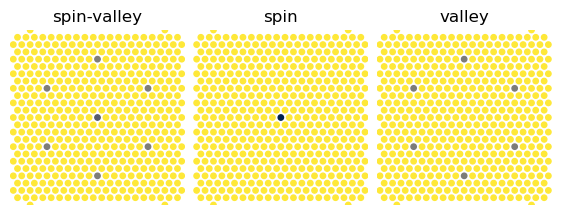

In [15]:
#Load checkpoint (contains last configuration)
cfg, current_sweep, energy, βs, σ = readCheckpointSA("SA_example.h5");

#Get allowed momenta of finite lattice in box arround origin
dimensions = [4π, 4π]
center = [0.0, 0.0]
ks = getKsInBox(latticename, L, dimensions, center)

#All possible connecting vectors between sites (if length(basis) = 1 these are just the sites)
rs = getRs(cfg) 

#Map all distances (r_i - r_j) to a value in rs using periodic boundary conditions
project = getProject(cfg) 

#Get correlations <T^μ T^μ> for all generators 
correlations = getCorrelations(cfg, project) #correlations as function of r_i - r_j for each r and each generator

#Compute structure factor summed over generators with specified components 
sf_spin = computeStructureFactor(correlations, rs, ks; components = [4, 8, 12]) #⟨σσ⟩ 
sf_valley = computeStructureFactor(correlations, rs, ks; components = [1, 2, 3]) #⟨ττ⟩
sf_spinvalley = computeStructureFactor(correlations, rs, ks; components = [5, 6, 7, 8, 10, 11, 12, 14, 15]) #⟨στ στ⟩

#Determine maxima and minima for equal colorscale
sfs = [sf_spinvalley, sf_spin, sf_valley]
vmin = minimum(minimum.(sfs)) #Minimal value for color scale
vmax = maximum(maximum.(sfs)) #Maximal value for color scale

#x and y component of momenta
kx = [k[1] for k in ks]
ky = [k[2] for k in ks]

#make plot
fig, ax = subplots(1, 3, figsize = (5.5, 2), layout = "constrained")

ax[1].scatter(kx, ky; c = sf_spinvalley, s = 15, cmap = "cividis_r", vmin = vmin, vmax = vmax)
ax[1].set_title("spin-valley")

ax[2].scatter(kx, ky; c = sf_spin, s = 15, cmap = "cividis_r", vmin = vmin, vmax = vmax)
ax[2].set_title("spin")

ax[3].scatter(kx, ky; c = sf_valley, s = 15, cmap = "cividis_r", vmin = vmin, vmax = vmax)
ax[3].set_title("valley")

for a in ax
    a.set(aspect = "equal", xlim = (-2π, 2π), ylim = (-2π, 2π))
    a.axis("off")
end